In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path :
    sys.path.append(module_path)

    
import _ressources.chain as chain
import _ressources.tools as tools
import _ressources.lumenclass as lc

from scipy.optimize import curve_fit

main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens'



Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv1/run0009/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 3.6666666666666665
        xi_v = 3.6666666666666665
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 1.00000
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.50000
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000



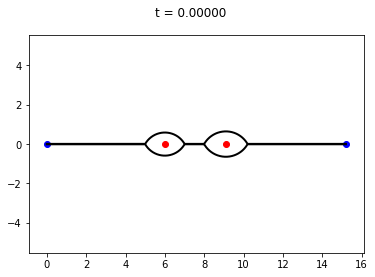

Import successful !


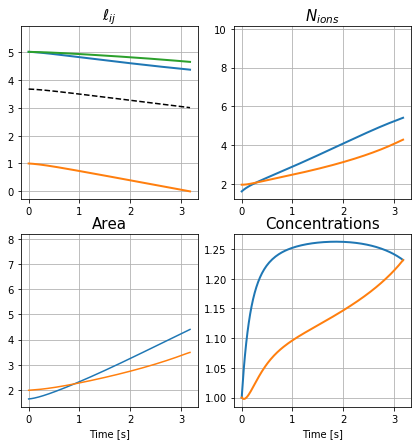

In [2]:
subdir = 'chis1/chiv1/run0009'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
print(ch)
x = np.linspace(0., ch.total_length, 1001)
tools.plot_profile(x, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

x_log = 0

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
    tools.plot_evolution(L, nions, ell, x_logscale=x_log)
else :
    L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
    tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)



# Pumping

In [40]:
def logscale(decades, points, scale=10) :
    Lscale = []
    for d in decades :
        for p in points :
            Lscale += [p*scale**d]
    return Lscale

def read_eventfile(eventfile) :
    s = open(eventfile, 'r').readlines()
    if '(C)' in s[-1].split() :
        return ('C', int(s[-1].split()[-1]))
    elif '(D)' in s[-1].split() :
        return ('D', int(s[-1].split()[-1]))
    elif '(M)' in s[-1].split() :
        return ('M', int(s[-1].split()[-1]))
    
def read_configfile(config_folder, param) :

    lumens = np.loadtxt(os.path.join(config_folder, 'lumens.dat'))
    bridges = np.loadtxt(os.path.join(config_folder, 'bridges.dat'))

    if param == 'ca' :
        return lumens[1:-1, -1], bridges[1:-1, -1]
    elif param == 'length' :
        return lumens[1:-1, 2], bridges[1:-1, 3]
    elif param == 'nb_ions' :
        return lumens[1:-1, 3]
    return None

def give_outputs(chi_list, folder, param) :
    out_chi = {}
    for chi in chi_list :
        out_chi[chi] = {}
        L = os.listdir(os.path.join(folder, 'chiv' + str(chi)))
        for elem in L :
            #if elem.startswith('run') :
            if elem.startswith('run') :
                eventfile = os.path.join(folder, 'chiv' + str(chi), elem, 'events.log')
                config_folder = os.path.join(folder, 'chiv' + str(chi), elem, 'config')
                try :
                    out_chi[chi][elem] = [read_configfile(config_folder, param), read_eventfile(eventfile)]
                except :
                    print(chi, elem)
    return out_chi

def plot_diagram(out, param_pos) :
    color_dict = {'M' : ['purple', 's'], 
                  'C' : {1 : ['blue', 'o'], 2 : ['red', 'o']}, 
                  'D' : ['green', '^']}
    for chi in out.keys() :
        print(str(chi) + '      ', end='\r')
        for sim in out[chi].keys() :
            y = out[chi][sim][0][param_pos[0]][param_pos[1]]
            
            try :
                fate, winner = out[chi][sim][1]
            except :
                print(chi, sim, out[chi][sim][1])                
            if fate == 'C' :
                color, symbol = color_dict[fate][winner]
            else :
                color, symbol = color_dict[fate]
            plt.scatter(float(chi), y, color = color, marker=symbol)
            
            
def write_paramfile(param_values, foldername) :
    ca_array = np.zeros((len(param_values), 3))
    for i in range(len(param_values)) :
        ca_array[i] = np.array([[param_values[i], 0., 0.5*param_values[i]]])
    np.savetxt(os.path.join(foldername, 'paramsfile.txt'), ca_array, header= ' l1:ca\tl2:ca\tb1:ca', fmt='%.5f')

In [23]:
decades = [-3, -2, -1, 0, 1, 2, 3]
points = [1, 2, 5]
scale = 10.
    
Lscale = logscale(decades = decades, points = points, scale = scale)


In [31]:
#for i in range(1, 10) :
subdir = 'chis1/chiv2.2'
write_paramfile(Lscale, oCs.path.join(main_dir, subdir))

In [38]:
chi_list = []
chi_list += ["{:.2f}".format(i*0.01) for i in range(1, 10)]
chi_list += ["{:.1f}".format(i*0.1) for i in range(1, 10)]
chi_list += [i for i in range(1, 51)]
chi_list += [1.5, 2.5]

out = give_outputs(chi_list, os.path.join(main_dir, 'chis1'), param='ca')


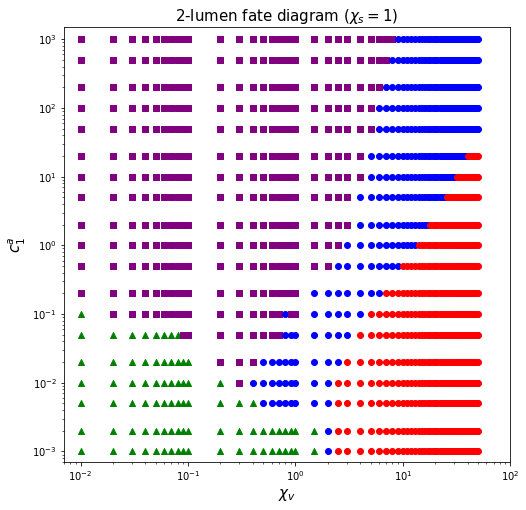

In [43]:
plt.figure(figsize=(8,8))

scale = 'log'
#scale = 'linear'
#scale = 'semilogy'

if scale == 'log' :
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(7e-3, 1e2)
    plt.ylim(7e-4, 1.5e3)
elif scale == 'semilogy' :
    plt.yscale('log')
    plt.xlim(7e-3, 51)
    plt.ylim(7e-4, 1.5e3)
elif scale == 'linear' :
    plt.xlim(0.01, 51)
    plt.ylim(0., 1001)
    
plot_diagram(out, param_pos=(0, 0))
plt.xlabel(r'$\chi_v$', fontsize=15)
plt.ylabel(r'$c^a_1$', fontsize=15)
plt.title(r'2-lumen fate diagram ($\chi_s=1$)', fontsize=15)
plt.savefig('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/fate_diagram_2lumens_chis1.eps', format='eps')
plt.show()

Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv0.01/run0005/config
Import successful !


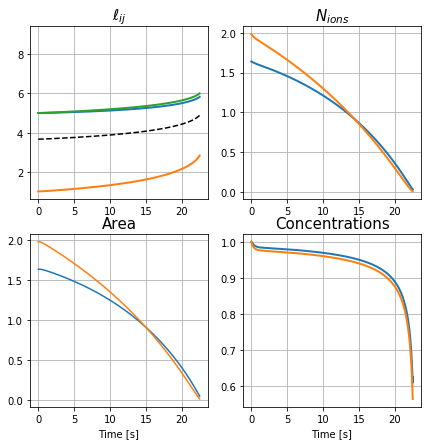

0.05
('D', 0)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv0.1/run0005/config
Import successful !


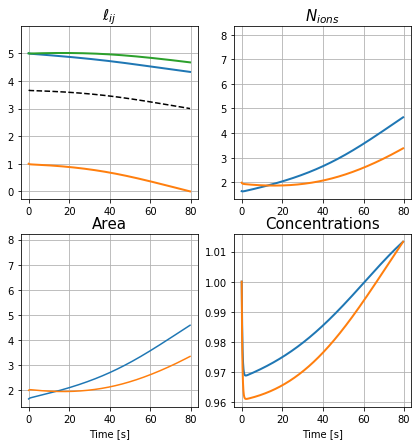

0.05
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv1/run0005/config
Import successful !


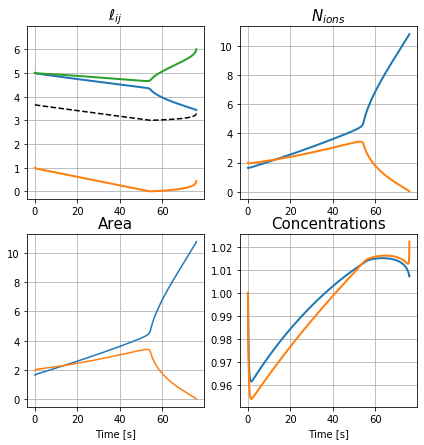

0.05
('C', 1)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv10/run0005/config
Import successful !


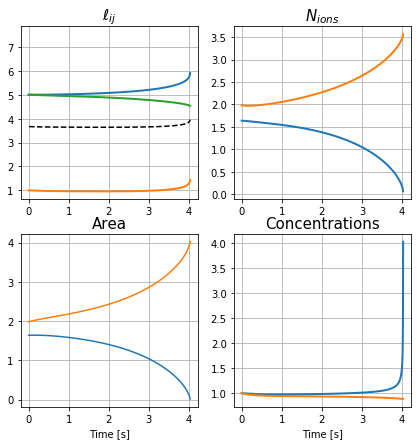

0.05
('C', 2)






In [47]:
for i in [1e-2, 1e-1, 1, 10] :
    subdir = 'chis1_bis/chiv'+str(i)+'/run0005'
    conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
    #print(ch)
    x = np.linspace(0., ch.total_length, 1001)
    #tools.plot_profile(x, ch)

    ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

    x_log = 0

    if ch.lumen_type == 'hydroosmotic' :
        L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
        tools.plot_evolution(L, nions, ell, x_logscale=x_log)
    else :
        L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
        tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)
    print(ch.lumens_dict[1].ca)
    print(read_eventfile(os.path.join(main_dir, subdir, 'events.log')))
    print('\n\n\n')